<a href="https://colab.research.google.com/github/Ananya-Ahuja/Anomalyze/blob/ananya_ahuja/Data_transfer_patterns_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    precision_recall_curve, accuracy_score, precision_score,
    recall_score, f1_score, pairwise_distances_argmin_min
)
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models

warnings.filterwarnings('ignore')

In [3]:
def load_and_combine(data_folder):
    combined_cols = [
        'uplink_volume', 'downlink_volume', 'total_volume',
        'session_duration', 'bytes_per_second', 'uplink_ratio', 'is_anomaly'
    ]
    transfer_cols = combined_cols[:-1]
    df_list = []

    for f in glob.glob(data_folder + '*.csv'):
        df = pd.read_csv(f, low_memory=False)
        # Keep only the columns that exist in this file
        cols = [c for c in combined_cols if c in df.columns]
        df = df[cols]
        # Add missing transfer columns
        for c in transfer_cols:
            if c not in df.columns:
                df[c] = pd.NA
        # Reorder columns to match combined_cols
        df = df[combined_cols]
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.dropna(
        subset=['uplink_volume', 'downlink_volume', 'total_volume', 'session_duration'],
        inplace=True
    )
    return combined_df

combined_df = load_and_combine('/content/datasets/')
print(f"Combined data shape: {combined_df.shape}")
true_labels = combined_df['is_anomaly'].astype(int)

Combined data shape: (70000, 7)


In [4]:
# ──────────── 2. FEATURE ENGINEERING ────────────
def engineer_features(df):
    transfer_cols = ['uplink_volume','downlink_volume','total_volume','session_duration','bytes_per_second','uplink_ratio']
    feats = df[transfer_cols].astype(float).fillna(0)
    # Basic ratios
    feats['uplink_downlink_ratio'] = feats['uplink_volume'] / (feats['downlink_volume'] + 1e-8)
    feats['volume_duration_ratio'] = feats['total_volume']  / (feats['session_duration'] + 1e-8)
    feats['bps_per_total_volume']  = feats['bytes_per_second'] / (feats['total_volume']     + 1e-8)
    # Rolling stats per session (if session_id exists; here global rolling)
    feats['rolling_vol_mean'] = feats['total_volume'].rolling(window=5, min_periods=1).mean()
    feats['rolling_vol_std']  = feats['total_volume'].rolling(window=5, min_periods=1).std().fillna(0)
    scaler = StandardScaler()
    X = scaler.fit_transform(feats)
    return X, scaler

X, scaler = engineer_features(combined_df)

In [5]:
# ──────────── 3. HANDLE CLASS IMBALANCE ────────────
X_res, y_res = SMOTE(random_state=42).fit_resample(X, true_labels)

In [6]:
# ──────────── 4. TRAIN/TEST SPLIT ────────────
X_train, X_test, y_train, y_test = train_test_split(
X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [7]:
# ──────────── 5. FIT BASE MODELS ────────────
# Isolation Forest
iso = IsolationForest(contamination=0.1, n_estimators=300, max_features=0.7, random_state=42, n_jobs=-1)
iso.fit(X_train)
iso_test_scores = iso.decision_function(X_test) # higher = normal

In [8]:
# K-Means distances
k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
k2.fit(X_train)
_, k_dist = pairwise_distances_argmin_min(X_test, k2.cluster_centers_)

In [9]:
# One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train)
svm_test_scores = ocsvm.decision_function(X_test) # higher = normal

In [10]:
# Autoencoder
input_dim = X_train.shape[1]
inp = layers.Input(shape=(input_dim,))
enc = layers.Dense(32, activation='relu')(inp)
enc = layers.Dense(16, activation='relu')(enc)
dec = layers.Dense(32, activation='relu')(enc)
dec = layers.Dense(input_dim, activation='linear')(dec)
autoencoder = models.Model(inputs=inp, outputs=dec)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, validation_split=0.1, verbose=0)
recon = autoencoder.predict(X_test)
ae_test_scores = np.mean(np.square(X_test - recon), axis=1) # higher = anomalous

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [11]:
# ──────────── 6. ENSEMBLE & THRESHOLD TUNING ────────────
best_recall = 0
best_weights = None
best_thr = None

for w1 in [0.2, 0.4, 0.6]:
    for w2 in [0.2, 0.4, 0.6]:
        for w3 in [0.2, 0.4]:
            w4 = 1.0 - (w1 + w2 + w3)
            if w4 < 0:
                continue
            ens_scores = (
                w1 * -iso_test_scores +
                w2 * k_dist +
                w3 * -svm_test_scores +
                w4 * ae_test_scores
            )
            prec, rec, thr = precision_recall_curve(y_test, ens_scores)
            # exclude last point
            prec, rec, thr = prec[:-1], rec[:-1], thr
            # require min precision
            valid = prec >= 0.1
            if valid.any():
                idx = np.argmax(rec[valid])
                r_val = rec[valid][idx]
                t_val = thr[valid][idx]
            else:
                idx = np.argmax(rec)
                r_val = rec[idx]
                t_val = thr[idx]
            if r_val > best_recall:
                best_recall = r_val
                best_weights = (w1, w2, w3, w4)
                best_thr = t_val

print(f"Best ensemble weights (ISO,KMeans,SVM,AE): {best_weights}, threshold={best_thr:.4f}")

final_scores = (
    best_weights[0] * -iso_test_scores +
    best_weights[1] * k_dist +
    best_weights[2] * -svm_test_scores +
    best_weights[3] * ae_test_scores
)
final_pred = (final_scores >= best_thr).astype(int)

Best ensemble weights (ISO,KMeans,SVM,AE): (0.2, 0.2, 0.2, 0.3999999999999999), threshold=-3.2472


In [12]:
# ──────────── 7. VALIDATION STABILITY (5-Fold CV) ────────────
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_preds, cv_truth = [], []
for tr_idx, val_idx in skf.split(X_res, y_res):
    X_tr, X_val = X_res[tr_idx], X_res[val_idx]
    y_tr, y_val = y_res[tr_idx], y_res[val_idx]
    # Refit base models
    iso.fit(X_tr); s_iso = iso.decision_function(X_val)
    k2.fit(X_tr); _, s_k = pairwise_distances_argmin_min(X_val, k2.cluster_centers_)
    ocsvm.fit(X_tr); s_svm = ocsvm.decision_function(X_val)
    autoencoder.fit(X_tr, X_tr, epochs=5, batch_size=256, verbose=0)
    recon = autoencoder.predict(X_val); s_ae = np.mean((X_val - recon)**2, axis=1)
    # Ensemble
    ens = (
        best_weights[0] * -s_iso +
        best_weights[1] * s_k +
        best_weights[2] * -s_svm +
        best_weights[3] * s_ae
    )
    cv_preds.append((ens >= best_thr).astype(int))
    cv_truth.append(y_val)
cv_preds = np.concatenate(cv_preds)
cv_truth = np.concatenate(cv_truth)
print("CV Precision:", precision_score(cv_truth, cv_preds))
print("CV Recall:   ", recall_score(cv_truth, cv_preds))
print("CV F1:       ", f1_score(cv_truth, cv_preds))

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
CV Precision: 0.5000375968117904
CV Recall:    1.0
CV F1:        0.6667000852173042


=== FINAL MODEL PERFORMANCE ===
Accuracy: 0.500
Precision: 0.500
Recall: 1.000
F1 Score: 0.667

=== FORENSIC-SPECIFIC METRICS ===
False Negatives: 0
Total Anomalies: 13300
False Negative Rate:0.000
Detection Rate: 1.000


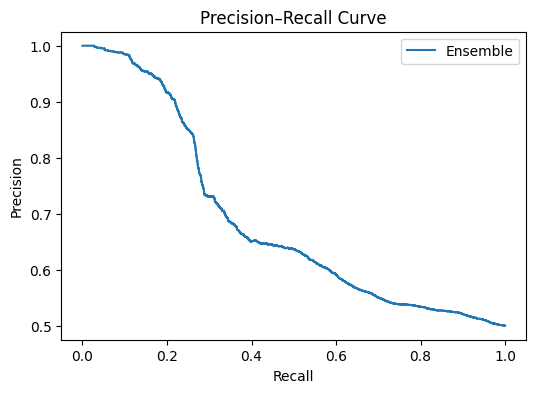

In [13]:
# ──────────── 8. FINAL EVALUATION & REPORT ────────────
acc = accuracy_score(y_test, final_pred)
prec = precision_score(y_test, final_pred)
rec = recall_score(y_test, final_pred)
f1 = f1_score(y_test, final_pred)
fn = ((y_test == 1) & (final_pred == 0)).sum()
tot = (y_test == 1).sum()

print("=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")
print("\n=== FORENSIC-SPECIFIC METRICS ===")
print(f"False Negatives: {fn}")
print(f"Total Anomalies: {tot}")
print(f"False Negative Rate:{fn/tot:.3f}")
print(f"Detection Rate: {1 - fn/tot:.3f}")

# Precision–Recall Curve
p, r, _ = precision_recall_curve(y_test, final_scores)
plt.figure(figsize=(6,4))
plt.plot(r, p, label='Ensemble')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(); plt.show()